Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

# Ignore FutureWarnings from Scikit-Learn to clean up plot outputs
warnings.filterwarnings("ignore", category=FutureWarning)

### Identify the correct path on own computer

**goal** : not to have to change any path manually when running the code

In [2]:
import sys
from pathlib import Path

# 1. Define the Project Root
# Start at the current directory and look for 'src' to identify the root
current_dir = Path.cwd()
project_root = current_dir

while not (project_root / 'src').exists():
    if project_root == project_root.parent:
        # Hit the filesystem root without finding the project
        raise FileNotFoundError("Could not find project root containing 'src'")
    project_root = project_root.parent

# 2. Add Project Root to System Path
# This allows 'import src...' to work from anywhere
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# 3. Define Key Paths
DATA_PATH = project_root / "data"
MODELS_PATH = project_root / "models"

# 4. Verification
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")
print(f"Models Path:  {MODELS_PATH}")

Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data
Models Path:  /home/delaunan/code/delaunan/clintrialpredict/models


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules/Closses
from src.prep.data_loader import ClinicalTrialLoader
from src.prep.preprocessing import preprocessor

### Loading of source data project_data.csv
Delete the one already present in clintrialpredict/data/ if you want the latest version. <br>
if data_project.csv already exists in clintrialpredict/data/, the existing one will not be replaced by the latest one <br>
**goal** : not to have to rerun and build the source file every time.

In [4]:
import pandas as pd
# We don't even need 'import os' if we use pathlib correctly

# 1. Define path using the '/' operator (works because DATA_PATH is a Path object)
CSV_PATH = DATA_PATH / 'project_data.csv'
FORCE_REGENERATE = False

# 2. Check existence using .exists() method
if CSV_PATH.exists() and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")

    # Ensure ClinicalTrialLoader is imported from your src
    # from src.WP5_utils.data_loader import ClinicalTrialLoader

    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (88374, 67)


### Audit of features in data_project.csv (to be runned only to dig deeper)
Audit file with all information saved to clintrialpredict/data/audit_features.txt

In [5]:
from src.prep.audit_utils import run_master_audit

#Run the audit of features loaded into project_data.csv (will generate audit_full_report.txt in your data folder)

run_master_audit(DATA_PATH)

Reading /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv...
[1/9] Checking Dataset Health...
[2/9] Analyzing Categorical Risk Signals...
[3/9] Analyzing Numerical Impact...
[4/9] Generating Preprocessing Strategy...
[5/9] Calculating Correlations...
[6/9] Ranking Categorical Features...
[7/9] Checking Collinearity...
[8/9] Running Business Logic Checks...
[9/9] Writing Documentation...

Done. Audit saved to /home/delaunan/code/delaunan/clintrialpredict/data/audit_features.txt


### Train Test Split (default 80/20)

In [6]:
from src.models.train_test_split import temporal_train_test_split

# --- TRAIN TEST SPLIT ---
SPLIT_PERCENTAGE = 0.80

print(f"\nTesting Split with {SPLIT_PERCENTAGE*100}% Training Data...")


X_train, X_test, y_train, y_test = temporal_train_test_split(df, train_ratio=SPLIT_PERCENTAGE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Testing Split with 80.0% Training Data...
X_train shape: (70699, 54)
y_train shape: (70699,)


In [7]:
import numpy as np

# 1. Count your zeros and ones
num_neg = np.sum(y_train == 0)
num_pos = np.sum(y_train == 1)

# 2. Calculate the ratio (Negatives / Positives)
# If you have fewer 1s, this number will be > 1, telling the model to pay more attention to them.
ratio = float(num_neg) / float(num_pos)

print(f"Count 0s (Negative): {num_neg}")
print(f"Count 1s (Positive): {num_pos}")
print(f"Calculated scale_pos_weight: {ratio:.4f}")

Count 0s (Negative): 60331
Count 1s (Positive): 10368
Calculated scale_pos_weight: 5.8190


### Model Training (model.fit)

In [8]:
from sklearn.linear_model import LogisticRegression
from src.prep.preprocessing import preprocessor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# --- 1. Define the Model ---
print("Initializing Logistic Regression...")
model = Pipeline([
    # The preprocessor will now include the new 'is_multi_phase' feature
    ('preprocessor', preprocessor()),
    ('classifier', XGBClassifier(
        # --- Core Parameters ---
        objective='binary:logistic',
        eval_metric='aucpr',

        # --- AGGRESSIVE REGULARIZATION (The settings that fixed the gap) ---
        n_estimators=300,            # Fixed low number
        learning_rate=0.02,          # Slow learning
        max_depth=3,                 # Shallow trees (CRITICAL)
        reg_lambda=15,               # Heavy L2 penalty
        gamma=1.0,                   # High minimum loss reduction
        min_child_weight=5,          # High minimum child weight

        # --- Standard Parameters ---
        subsample=0.8,
        colsample_bytree=0.8,

        # --- Imbalance Handling ---
        scale_pos_weight=ratio,

        # --- Technical Settings ---
        random_state=42,
        n_jobs=1,
        tree_method='hist'
    ))
])


# --- Fit the Model ---
print("Fitting XGBoost Model...")
model.fit(X_train, y_train)
print("✅ XGBoost Model Trained!")

Initializing Logistic Regression...
Fitting XGBoost Model...
✅ XGBoost Model Trained!



 PERFORMANCE AUDIT: Logistic Regression (Baseline)

[1] DISCRIMINATORY POWER (ROC-AUC): 0.7779
    - Industry Benchmark: 0.70 (Public Data) | 0.78+ (Proprietary Data)
    - Status: ✅ Strong

[2] FAILURE DETECTION CAPABILITY (PR-AUC): 0.4444
    - Baseline (Random Guess): 0.1946
    - Lift: 2.3x better than random guessing.

[3] PROBABILITY RELIABILITY (Brier Score): 0.1835
    - Goal: < 0.15 for high-confidence financial modeling.
--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT (With Interpretation):
                precision    recall  f1-score   support

 Completed (0)       0.90      0.72      0.80     14235   <-- Correctly approves 72% of safe trials
Terminated (1)       0.37      0.69      0.48      3440   <-- Catches 69% of failures (Precision: 37%)

      accuracy                           0.71     17675
     macro avg       0.64      0.70      0.64     17675
  weighted avg       0.80      0.71      0.74     17675


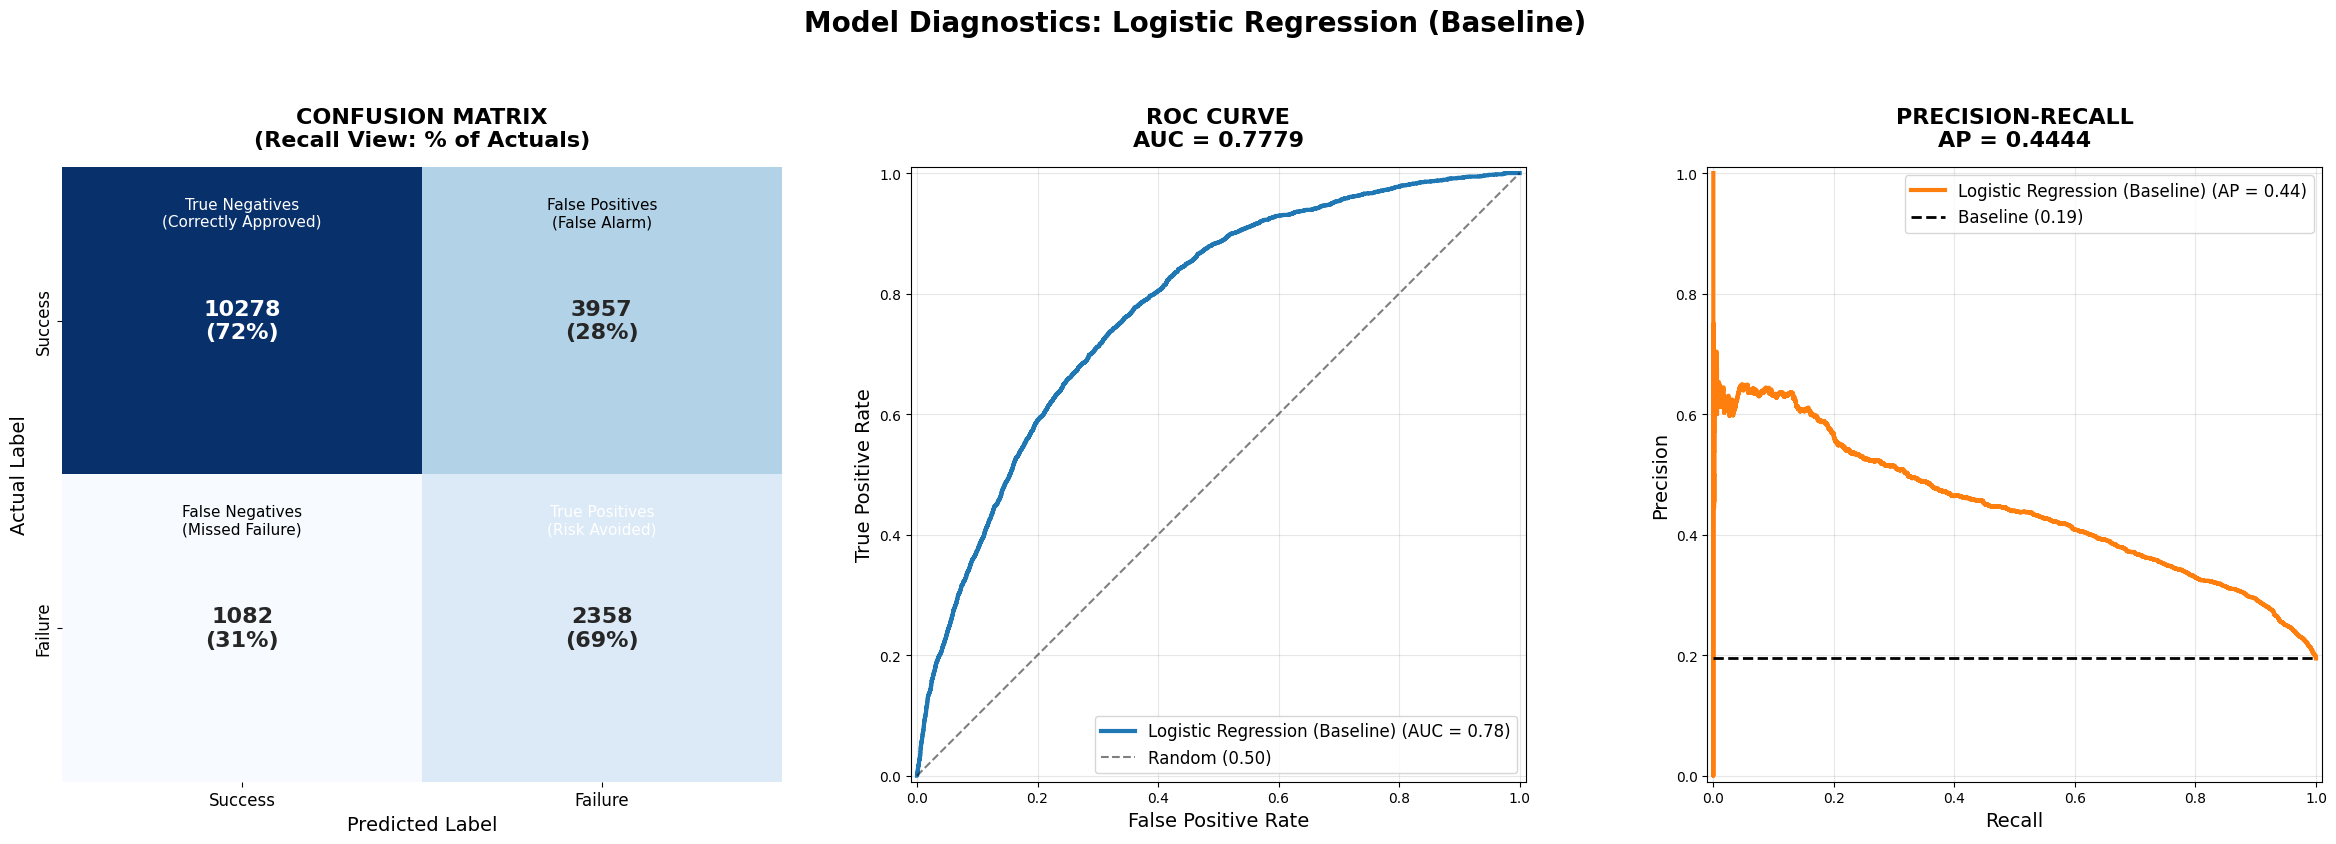


 DIAGNOSTIC: TEMPORAL LEARNING CURVE
Computing learning curve... (This may take a moment)

[RESULTS]
Final Training Score:   0.8108
Final Validation Score: 0.6796
Generalization Gap:     0.1313
>> DIAGNOSIS: High Overfitting. The model is memorizing historical noise.


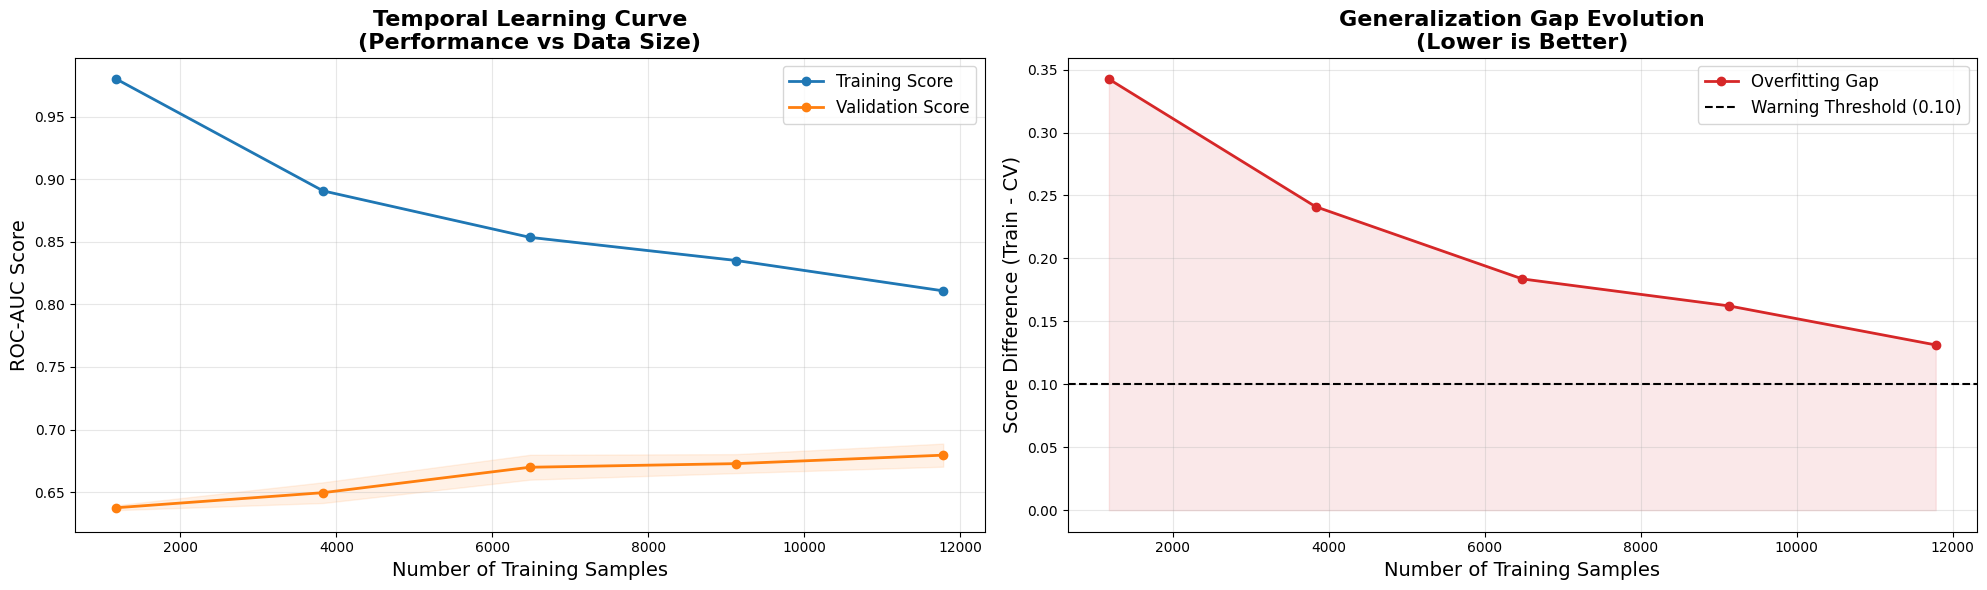


 💼 BUSINESS INTELLIGENCE: CROSS-SEGMENT ANALYSIS (FULL LIST)

[1] MAIN DIMENSIONS (Single Factors)
   Dimension       Segment  Count Fail_Rate ROC_AUC
       PHASE        PHASE1   6915     14.2%   0.829
       PHASE PHASE2/PHASE3    645     21.4%   0.780
       PHASE PHASE1/PHASE2   1421     31.4%   0.768
       PHASE        PHASE3   3344     16.1%   0.743
       PHASE        PHASE2   5350     25.0%   0.691
AGENCY_CLASS     OTHER_GOV    225      6.2%   0.845
AGENCY_CLASS         INDIV      7     28.6%   0.800
AGENCY_CLASS       NETWORK     78     23.1%   0.796
AGENCY_CLASS      INDUSTRY  11595     18.3%   0.793
AGENCY_CLASS           NIH    244     30.3%   0.775
AGENCY_CLASS           FED     47     19.1%   0.760
AGENCY_CLASS         OTHER   5479     21.9%   0.746

[2] CROSS-SEGMENTS (Agency + Phase Interaction) - ALL ROWS
                  Segment  Count Fail_Rate ROC_AUC
      FED / PHASE1/PHASE2      6     16.7%   1.000
OTHER_GOV / PHASE1/PHASE2     32      6.2%   1.000
           

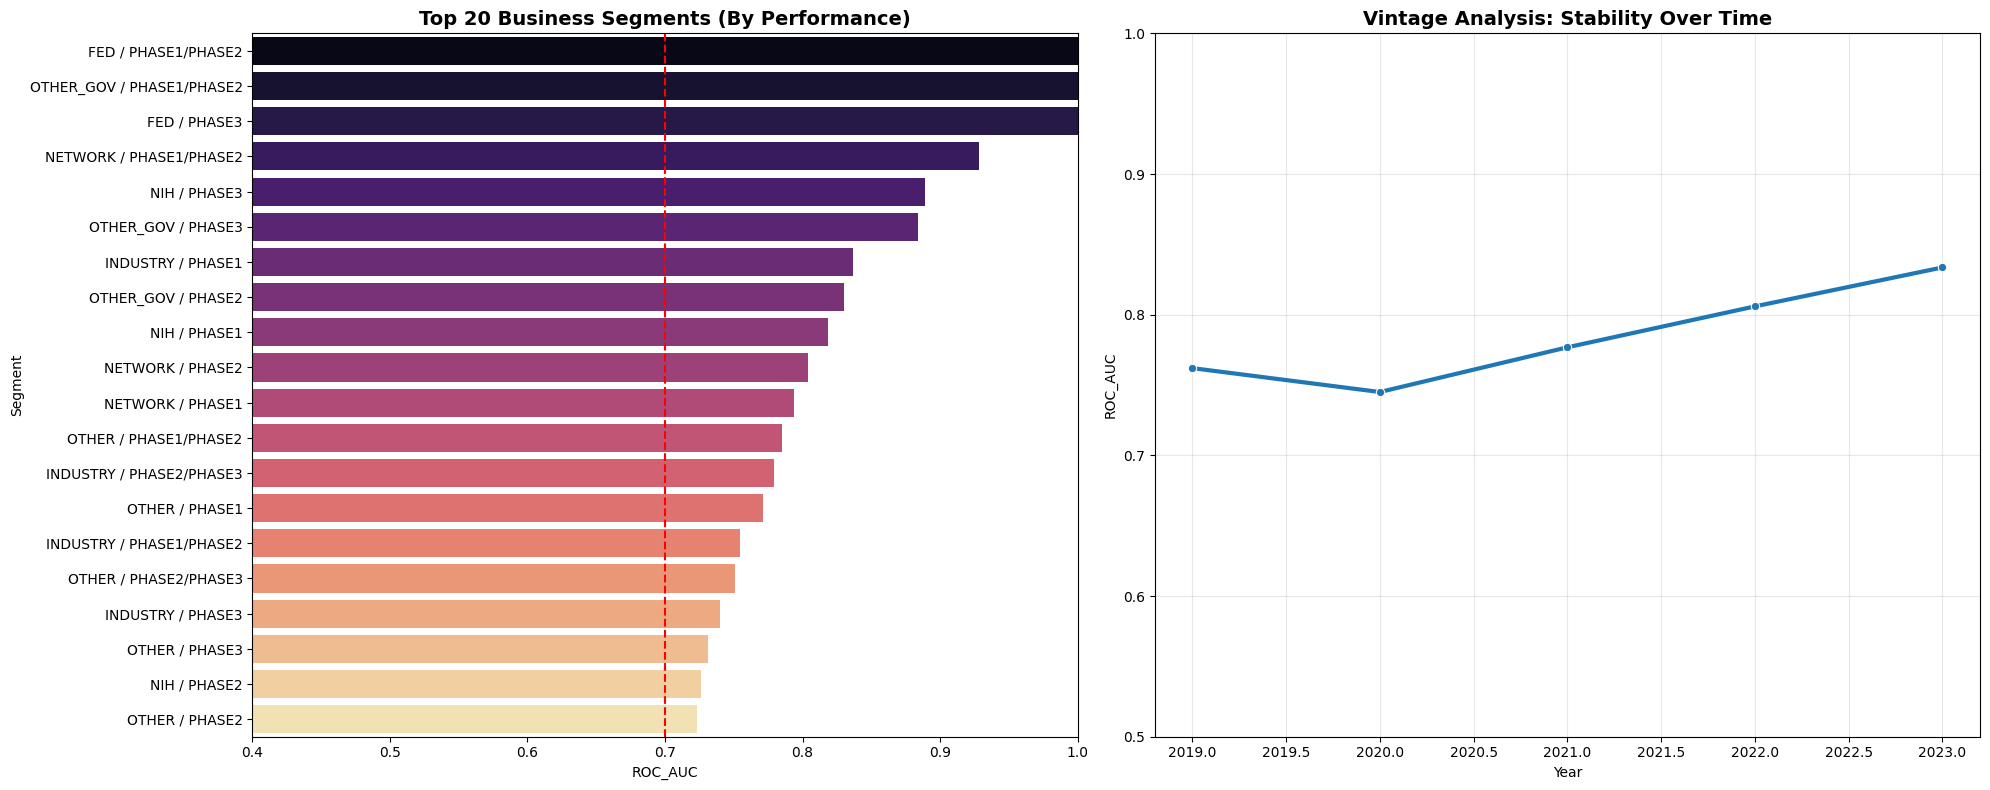

In [9]:
from src.models.evaluate import evaluate_model
# --- 2. RUN STANDARD EVALUATION ---
# This generates the Scorecard, Confusion Matrix, ROC, and PR Curves

metrics = evaluate_model(model, X_test, y_test, model_name="Logistic Regression (Baseline)")

from src.models.evaluate import plot_learning_curve

# --- 1. RUN TEMPORAL LEARNING CURVE ---
# This generates the Learning Curve to check for Overfitting/Underfitting
# cv=5 means it will test on 5 different time periods (expanding window)

plot_learning_curve(model, X_train, y_train, cv=5)

from src.models.evaluate_01 import evaluate_business_slices

# 1. Manually recreate the Test Split (Metadata + Features)
df_sorted = df.sort_values('start_date').reset_index(drop=True)
split_index = int(len(df_sorted) * 0.80)
df_test_full = df_sorted.iloc[split_index:].copy()

# ---------------------------------------------------------
# CRITICAL FIX: Generate Predictions First
# ---------------------------------------------------------
# We assume 'X_test' is the encoded feature set you used to validate the model.
# It must match the rows of df_test_full exactly.
df_test_full['y_prob'] = model.predict_proba(X_test)[:, 1]

# ---------------------------------------------------------
# 2. Run the Business Analysis
# ---------------------------------------------------------
# Correct Call: Pass ONLY the dataframe (now containing 'y_prob')
evaluate_business_slices(df_test_full)

### How to Read the Graphs (Cheat Sheet)

**1. Confusion Matrix (Operational Impact)**
*   **Bottom Left (False Negatives):** The "Capital Loss" quadrant. The model said "Safe", but the trial failed. Investors lose money here.
*   **Top Right (False Positives):** The "Opportunity Cost" quadrant. The model said "Risky", but the trial succeeded. Pharma misses a good drug here.

**2. ROC Curve (Global Separability)**
*   **What it tells us:** How good is the model generally?
*   **The Line:** The more it hugs the top-left corner, the better.
*   **The Diagonal:** If the line is on the diagonal, the model is guessing (useless).

**3. Precision-Recall Curve (The Imbalance Truth)**
*   **What it tells us:** Can we trust the "Risk" flags?
*   **Context:** Since failures are rare (15%), this is the most honest view.
*   **The Baseline:** The dashed line represents the failure rate (0.15). We want our curve to be significantly higher than this line.

**4. Temporal Learning Curve (Stability)**
*   **Blue Line:** How well the model knows history.
*   **Orange Line:** How well the model predicts the future.
*   **Convergence:** We want the Orange line to go UP and get closer to the Blue line as we add more data. If the Orange line stays flat, adding more data won't help (we need better features).

### Save model (not to have to re-run model.fit next time so that you start with the correct weights)
prerequisite will be Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.

In [10]:
import joblib

# 1. Define the filename in a variable
MODEL_FILENAME = 'logreg_baseline.joblib'

# 2. Construct the full path using the pathlib object
# This ensures it goes to 'CLINTRIALPREDICT/models/', not 'src/models/'
save_path = MODELS_PATH / MODEL_FILENAME

# 3. Save the model
print(f"Saving model to: {save_path} ...")
joblib.dump(model, save_path)

print(f"✅ Model successfully saved as '{MODEL_FILENAME}' in the project root models folder.")

Saving model to: /home/delaunan/code/delaunan/clintrialpredict/models/logreg_baseline.joblib ...
✅ Model successfully saved as 'logreg_baseline.joblib' in the project root models folder.


### Imprort pre-trained model (not to have to re-run model.fit)
prerequisite Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.


### **1. Install SHAP**
First, we need to make sure the library is available in your environment.


### ** 2. Prepare the Data for the Explainer**

**The Logic:**
Your `model` is a **Pipeline** (Preprocessor + XGBoost).
*   **XGBoost** (the model) only understands numbers (matrices).
*   **X_test** (your data) contains text, categories, and raw numbers.

SHAP needs to see the data exactly how XGBoost sees it. We cannot just pass `X_test` to SHAP; it will break. We must manually run the **Preprocessor** first to turn the text/categories into the final matrix of numbers.

**The Code:**
Copy this into your notebook. It extracts the preprocessor, transforms the data, and retrieves the column names (which we need for your Business Pillars later).

In [11]:
import shap
import pandas as pd
import numpy as np

# 1. Extract the two parts of your pipeline
# 'preprocessor' handles the data transformation
# 'classifier' is the actual XGBoost model
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']

print(">>> Transforming X_test for SHAP analysis...")

# 2. Transform the raw X_test into the numeric format XGBoost actually used
# This applies your Log, Scaling, OneHot, TargetEncoding, and Embeddings
X_test_transformed = preprocessor.transform(X_test)

# 3. Recover Feature Names
# We need these names to map "col_57" back to "Agency Class" or "Emb_0"
try:
    # This works for modern scikit-learn versions
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback just in case
    print("Warning: Could not get specific feature names. Generating indices.")
    feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

# 4. Create a clean DataFrame for SHAP
# This makes the analysis much easier to read
X_test_encoded = pd.DataFrame(
    X_test_transformed,
    columns=feature_names
)

print(f"✅ Data Prepared.")
print(f"   - Original X_test Shape: {X_test.shape}")
print(f"   - Transformed Shape:     {X_test_encoded.shape}")
print(f"   - Sample Feature Names:  {list(X_test_encoded.columns[:5])}")


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> Transforming X_test for SHAP analysis...
✅ Data Prepared.
   - Original X_test Shape: (17675, 54)
   - Transformed Shape:     (17675, 113)
   - Sample Feature Names:  ['competition_broad', 'competition_niche', 'num_primary_endpoints', 'number_of_arms', 'design_rigor_score']


**Stop and Check:**

1.  Look at the **Transformed Shape**. Does the number of columns make sense? (If you removed PCA and kept 20 embeddings, plus your other features, it should be around 50-80 columns).
2.  Look at **Sample Feature Names**. Do you see names like `cat_onehot__phase` or `embeddings__emb_0`?

In [12]:
# --- AUDIT RAW FEATURES (X_test) ---

# 1. Get the list of raw columns
raw_cols = X_test.columns.tolist()

print(f"📊 Total Raw Features: {len(raw_cols)}")
print("-" * 60)

# 2. Check for Key Groups based on your Taxonomy
# We define what we EXPECT to see based on your requirements
expected_groups = {
    "Pillar 1: Patient & Criteria": [
        "gender", "min_age_years", "child", "adult", "older_adult",
        "healthy_volunteers", "eligibility_strictness_score", "criteria_len_log"
    ],
    "Pillar 2: Therapeutic Landscape": [
        "agent_category", "is_fda_regulated_drug", "therapeutic_area",
        "competition_broad", "competition_niche"
    ],
    "Pillar 3: Protocol Design": [
        "phase", "masking", "allocation", "intervention_model", "primary_purpose",
        "number_of_arms", "num_primary_endpoints", "has_dmc", "design_rigor_score"
    ],
    "Pillar 4: Sponsor & Ops": [
        "sponsor_tier", "agency_class", "lead_sponsor", "includes_us", "start_year"
    ],
    "Embeddings (Recruitment Text)": [f"emb_{i}" for i in range(5)] # Checking first 5 as sample
}

# 3. Print the Audit
for group, features in expected_groups.items():
    print(f"\n🔍 Checking {group}:")
    found = []
    missing = []
    for f in features:
        if f in raw_cols:
            found.append(f)
        else:
            missing.append(f)

    print(f"   ✅ Found ({len(found)}): {found}")
    if missing:
        print(f"   ❌ Missing: {missing}")
    else:
        print("   ✨ All key features present.")

# 4. Check Embedding Count specifically
emb_cols = [c for c in raw_cols if "emb_" in c]
print("-" * 60)
print(f"🧬 Total Embedding Columns Found: {len(emb_cols)}")
if len(emb_cols) == 20:
    print("   ✅ Correct count (20 embeddings).")
else:
    print(f"   ⚠️ Unexpected count (Expected 20, found {len(emb_cols)})")

# 5. List ALL columns (for manual review)
print("-" * 60)
print("Full Column List:")
print(raw_cols)

📊 Total Raw Features: 54
------------------------------------------------------------

🔍 Checking Pillar 1: Patient & Criteria:
   ✅ Found (7): ['gender', 'child', 'adult', 'older_adult', 'healthy_volunteers', 'eligibility_strictness_score', 'criteria_len_log']
   ❌ Missing: ['min_age_years']

🔍 Checking Pillar 2: Therapeutic Landscape:
   ✅ Found (5): ['agent_category', 'is_fda_regulated_drug', 'therapeutic_area', 'competition_broad', 'competition_niche']
   ✨ All key features present.

🔍 Checking Pillar 3: Protocol Design:
   ✅ Found (9): ['phase', 'masking', 'allocation', 'intervention_model', 'primary_purpose', 'number_of_arms', 'num_primary_endpoints', 'has_dmc', 'design_rigor_score']
   ✨ All key features present.

🔍 Checking Pillar 4: Sponsor & Ops:
   ✅ Found (3): ['sponsor_tier', 'agency_class', 'includes_us']
   ❌ Missing: ['lead_sponsor', 'start_year']

🔍 Checking Embeddings (Recruitment Text):
   ✅ Found (5): ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4']
   ✨ All key featur

### **Cell 3: Calculate the SHAP Values**

**The Logic:**
Now that we have the numeric data (`X_test_encoded`), we feed it into the **TreeExplainer**. This tool looks at the XGBoost trees and calculates exactly how much each feature pushed the probability of "Failure" up or down for every single trial.

**The Code:**

In [13]:
# --- STEP 3: CALCULATE SHAP VALUES ---

print(">>> Initializing SHAP TreeExplainer...")

# 1. Create the Explainer using the XGBoost part of the pipeline
explainer = shap.TreeExplainer(classifier)

# 2. Calculate SHAP values
# This might take 30 seconds to 2 minutes depending on your dataset size
print(f"    Calculating SHAP values for {len(X_test_encoded)} samples...")
shap_values = explainer(X_test_encoded)

# 3. Verification
print(f"✅ Calculation Complete.")
print(f"   - SHAP Values Shape: {shap_values.values.shape}")

# 4. Quick Sanity Check: Show top 3 drivers for the first trial in the test set
print("\n   [Sanity Check] Top drivers for the first trial:")
sample_idx = 0
# Find indices of the top 3 most impactful features for this specific trial
top_indices = np.argsort(np.abs(shap_values.values[sample_idx]))[-3:][::-1]

for i in top_indices:
    feat_name = X_test_encoded.columns[i]
    score = shap_values.values[sample_idx][i]
    print(f"    * {feat_name}: {score:.4f}")


>>> Initializing SHAP TreeExplainer...
    Calculating SHAP values for 17675 samples...
✅ Calculation Complete.
   - SHAP Values Shape: (17675, 113)

   [Sanity Check] Top drivers for the first trial:
    * sponsor_clean: 0.3110
    * therapeutic_subgroup_name: -0.1592
    * therapeutic_area: -0.1285


The sanity check confirms your model is using logical features (`sponsor_clean`, `therapeutic_subgroup_name`) to make decisions.

Now we move to the most important part for your dashboard: **Aggregation**.

### **4. Define the Business Logic (The Taxonomy)**

**The Concept:**
We have 113 specific features (e.g., `emb_0`, `emb_1`, `phase_PHASE2`, `sponsor_clean`). We need to group them into your **4 Business Pillars**.

To do this, we will write a Python function that looks at every feature name and assigns it a **Pillar** and a **Subcategory**.

**The Code:**
Copy this into a new cell. This is a pure logic cell (no calculation yet), defining the rules we agreed upon.

In [14]:
# --- STEP 4: DEFINE FEATURE MAPPING LOGIC ---

def map_feature_to_business_pillar(feature_name):
    """
    Maps a raw feature name (e.g., 'emb_5', 'phase_PHASE3')
    to a Business Pillar and Subcategory.
    """
    # Convert to string and lower case for easier matching
    name = str(feature_name).lower()

    # --- PILLAR 1: PATIENT & CRITERIA FEASIBILITY ---
    # 1. Criteria Complexity (AI Signal)
    if 'emb_' in name or 'pca' in name:
        return 'Patient & Criteria', 'Criteria Complexity'

    # 2. Inclusion Constraints
    if any(x in name for x in ['eligibility', 'strictness', 'criteria_len']):
        return 'Patient & Criteria', 'Inclusion Constraints'

    # 3. Demographics
    if any(x in name for x in ['gender', 'age', 'child', 'adult', 'older']):
        return 'Patient & Criteria', 'Demographics'

    # 4. Patient Condition
    if any(x in name for x in ['healthy', 'sick', 'condition']):
        return 'Patient & Criteria', 'Patient Condition'

    # --- PILLAR 2: THERAPEUTIC LANDSCAPE ---
    # 1. Intervention Profile
    if any(x in name for x in ['agent', 'fda', 'drug', 'intervention']):
        return 'Therapeutic Landscape', 'Intervention Profile'

    # 2. Disease Area
    if any(x in name for x in ['therapeutic', 'pathology', 'disease']):
        return 'Therapeutic Landscape', 'Disease Area'

    # 3. Competitive Intensity
    if 'competition' in name:
        return 'Therapeutic Landscape', 'Competitive Intensity'

    # --- PILLAR 3: PROTOCOL DESIGN ---
    # 1. Scientific Rigor
    if any(x in name for x in ['rigor', 'masking', 'allocation', 'randomized']):
        return 'Protocol Design', 'Scientific Rigor'

    # 2. Study Configuration
    if any(x in name for x in ['phase', 'purpose', 'model', 'study_type']):
        return 'Protocol Design', 'Study Configuration'

    # 3. Complexity & Safety
    if any(x in name for x in ['arms', 'endpoints', 'dmc']):
        return 'Protocol Design', 'Complexity & Safety'

    # --- PILLAR 4: SPONSOR & OPERATIONS ---
    # 1. Sponsor Capability
    if any(x in name for x in ['sponsor', 'agency']):
        return 'Sponsor & Operations', 'Sponsor Capability'

    # 2. Geography & Context
    if any(x in name for x in ['us', 'year', 'country', 'location']):
        return 'Sponsor & Operations', 'Geography & Context'

    # --- FALLBACK ---
    return 'Other', 'Unclassified'

print("✅ Mapping Logic Defined.")
# Test it on a few examples
test_feats = ['emb_12', 'sponsor_clean', 'phase_PHASE3', 'competition_broad']
for f in test_feats:
    print(f"   - {f} -> {map_feature_to_business_pillar(f)}")

✅ Mapping Logic Defined.
   - emb_12 -> ('Patient & Criteria', 'Criteria Complexity')
   - sponsor_clean -> ('Sponsor & Operations', 'Sponsor Capability')
   - phase_PHASE3 -> ('Protocol Design', 'Study Configuration')
   - competition_broad -> ('Therapeutic Landscape', 'Competitive Intensity')


**Run this cell.**
Check the output at the bottom. It should correctly map:
*   `emb_12` -> Patient & Criteria
*   `sponsor_clean` -> Sponsor & Operations

If the mapping looks correct, tell me, and we will proceed to **Step 5: Applying this to the Data**.

Before we calculate scores, we must ensure our "dictionary" (the mapping function) actually covers the specific words in your "book" (the dataset).

We will now run a **Validation Step**. We will take the actual column names from `X_test_encoded` (which we created in Step 1) and run them through the mapping function to see what lands in "Other / Unclassified".

### **Step 5: Validate Feature Coverage**

**The Concept:**
We will loop through all 113 columns in your dataframe. If a feature ends up as "Other", we print it out. This allows you to decide if you need to update the mapping logic or if those features are safe to ignore.

**The Code:**
Copy and run this cell.

In [15]:

# --- STEP 5: VALIDATE MAPPING COVERAGE ---

# 1. Get the actual feature names from the dataframe we prepared earlier
actual_features = X_test_encoded.columns.tolist()

# 2. Apply the mapping to every single feature
mapping_results = []
for feature in actual_features:
    pillar, subcat = map_feature_to_business_pillar(feature)
    mapping_results.append({
        'Feature': feature,
        'Pillar': pillar,
        'Subcategory': subcat
    })

# 3. Convert to DataFrame for easy analysis
df_mapping = pd.DataFrame(mapping_results)

# 4. Check for Unclassified features (The "Fallbacks")
unclassified = df_mapping[df_mapping['Pillar'] == 'Other']

print(f"Total Features: {len(df_mapping)}")
print(f"Mapped Features: {len(df_mapping) - len(unclassified)}")
print(f"Unclassified Features: {len(unclassified)}")

if len(unclassified) > 0:
    print("\n⚠️ The following features fell into 'Other'. Do we need to add rules for them?")
    print(unclassified['Feature'].tolist())
else:
    print("\n✅ Success! Every single feature was assigned to a Business Pillar.")


Total Features: 113
Mapped Features: 113
Unclassified Features: 0

✅ Success! Every single feature was assigned to a Business Pillar.


In [16]:
# --- STEP 6 & 7 REVISED: AGGREGATE & CALCULATE PROBABILITIES ---

# 1. Create Mapping Dictionaries based on your VALIDATED logic
pillar_map = {}
subcat_map = {}

for col in X_test_encoded.columns:
    # This uses the function we just validated
    pillar, subcat = map_feature_to_business_pillar(col)
    pillar_map[col] = pillar
    subcat_map[col] = subcat

# 2. Create a temporary dataframe of raw values
df_shap_raw = pd.DataFrame(shap_values.values, columns=X_test_encoded.columns)

# 3. Group by Pillar & Subcategory (This removes the "Other" category)
df_pillars = df_shap_raw.groupby(pillar_map, axis=1).sum()
df_subcategories = df_shap_raw.groupby(subcat_map, axis=1).sum()

# 4. Add the Base Value back (Required for the math)
df_pillars['Base Value'] = shap_values.base_values

# 5. Calculate Risk Probability (Step 7 Logic)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Sum all pillars + base value to get total log odds
df_pillars['Total Log-Odds'] = df_pillars.sum(axis=1)
# Convert to 0-100% probability
df_pillars['Risk Probability'] = df_pillars['Total Log-Odds'].apply(sigmoid)

print("✅ Data Refreshed & Probabilities Calculated.")
print(f"   - Pillars found: {list(df_pillars.columns)}")
print(f"   - 'Other' category exists? {'Other' in df_pillars.columns}")

✅ Data Refreshed & Probabilities Calculated.
   - Pillars found: ['Patient & Criteria', 'Protocol Design', 'Sponsor & Operations', 'Therapeutic Landscape', 'Base Value', 'Total Log-Odds', 'Risk Probability']
   - 'Other' category exists? False


In [17]:
# --- 1. UNIFIED MATH ENGINE (Run this first) ---
import pandas as pd
import numpy as np
import plotly.express as px

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_unified_impact_data(trial_index, df_subcategories, df_pillars):
    """
    Generates perfectly consistent data for both Bar Chart and Treemap.
    """
    # 1. Get Base Value (Starting Point)
    base_log_odds = df_pillars.iloc[trial_index]['Base Value']
    prob_fail_base = sigmoid(base_log_odds)
    prob_success_base = 1 - prob_fail_base

    # 2. Get Raw SHAP values for Subcategories
    row_sub = df_subcategories.iloc[trial_index]

    # 3. Calculate Total SHAP and Final Probability
    total_shap_log_odds = row_sub.sum()
    prob_fail_final = sigmoid(base_log_odds + total_shap_log_odds)
    prob_success_final = 1 - prob_fail_final

    # 4. Calculate Scale Factor (Linearization)
    total_gap = prob_success_final - prob_success_base

    if abs(total_shap_log_odds) < 1e-9:
        scale_factor = 0
    else:
        scale_factor = total_gap / total_shap_log_odds

    # 5. Build Subcategory Data (The Atomic Level)
    subcat_records = []
    for col in df_subcategories.columns:
        pillar, subcat = map_feature_to_business_pillar(col)
        if pillar == 'Other': continue

        # Calculate % Impact
        # Note: No manual -1. Scale factor handles the sign flip (Risk -> Success)
        val_pct = row_sub[col] * scale_factor

        subcat_records.append({
            'Pillar': pillar,
            'Subcategory': subcat,
            'Impact_Pct': val_pct
        })

    df_sub = pd.DataFrame(subcat_records)

    # 6. Build Pillar Data (By summing Subcategories)
    # This guarantees they match perfectly
    df_pil = df_sub.groupby('Pillar')['Impact_Pct'].sum().reset_index()

    return df_pil, df_sub, prob_success_base, prob_success_final

In [18]:
import plotly.express as px
import pandas as pd
import numpy as np

def plot_success_bar_spaced(trial_index, df_subcategories, df_pillars):
    # 1. Get Unified Data
    df_pil, _, prob_base, prob_final = get_unified_impact_data(trial_index, df_subcategories, df_pillars)

    # 2. Sort
    df_pil = df_pil.sort_values('Impact_Pct', ascending=True)

    # 3. Color Bounds
    max_abs = max(abs(df_pil['Impact_Pct'].min()), abs(df_pil['Impact_Pct'].max()))

    # 4. Custom Color Scale
    custom_scale = [
        (0.00, "#8B0000"),  # Max Risk: Deep Red
        (0.49, "#EF9A9A"),  # Small Risk: Soft Red
        (0.50, "#FFFFFF"),  # Zero: White
        (0.51, "#A5D6A7"),  # Small Success: Soft Green
        (1.00, "#006400")   # Max Success: Deep Green
    ]

    # 5. Plot
    fig = px.bar(
        df_pil,
        x='Impact_Pct',
        y='Pillar',
        color='Impact_Pct',
        orientation='h',
        color_continuous_scale=custom_scale,
        range_color=[-max_abs, max_abs]
    )

    # 6. Styling
    fig.update_traces(
        texttemplate='%{x:+.1%}',
        textposition='outside',
        textfont_color='black',
        textfont_weight='bold',
        textfont_size=12,
        cliponaxis=False,
        width=0.8
    )

    fig.update_layout(
        title=None,
        xaxis_title="",
        yaxis_title="",
        showlegend=False,
        coloraxis_showscale=False,

        # --- SIZE & MARGINS ---
        width=400,
        height=180,
        bargap=0.15,

        # Increased Left Margin to accommodate the extra padding
        margin=dict(l=150, r=45, t=10, b=10),

        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=11, color='black')
    )

    fig.add_vline(x=0, line_width=1.5, line_color="#333333", opacity=1)

    # X-Axis Zoom
    x_min = df_pil['Impact_Pct'].min()
    x_max = df_pil['Impact_Pct'].max()

    if x_min == 0 and x_max == 0:
        x_range = [-0.1, 0.1]
    else:
        x_range = [x_min * 1.35, x_max * 1.35]

    fig.update_xaxes(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
        range=x_range
    )

    fig.update_yaxes(
        tickfont=dict(size=11, color='black'),
        # INCREASED PADDING HERE:
        ticksuffix="      ",
        automargin=True
    )

    fig.show()

# Test
plot_success_bar_spaced(0, df_subcategories, df_pillars)

In [19]:
def sigmoid(x):
    """Converts Log-Odds (SHAP sum) into Probability (0-100%)"""
    return 1 / (1 + np.exp(-x))

# 1. Calculate the Total Log-Odds Score for every trial
# We sum the 4 pillars + the base value
df_pillars['Total Log-Odds'] = (
    df_pillars['Patient & Criteria'] +
    df_pillars['Therapeutic Landscape'] +
    df_pillars['Protocol Design'] +
    df_pillars['Sponsor & Operations'] +
    df_pillars['Base Value']
)

# 2. Convert to Probability (Risk Score)
df_pillars['Risk Probability'] = df_pillars['Total Log-Odds'].apply(sigmoid)

# 3. Verify the calculation for Trial #0
print(">>> Verification for Trial #0:")
print(f"   - Total Log-Odds:   {df_pillars.iloc[0]['Total Log-Odds']:.4f}")
print(f"   - Risk Probability: {df_pillars.iloc[0]['Risk Probability']:.2%}")

# 4. Save this data! We will need it for the Streamlit App.
# We save both the Pillars (High level) and Subcategories (Detail level)
print("\n>>> Saving Processed SHAP Data...")
df_pillars.to_csv('shap_pillars.csv', index=False)
df_subcategories.to_csv('shap_subcategories.csv', index=False)
print("✅ Saved 'shap_pillars.csv' and 'shap_subcategories.csv'")

>>> Verification for Trial #0:
   - Total Log-Odds:   0.3583
   - Risk Probability: 58.86%

>>> Saving Processed SHAP Data...
✅ Saved 'shap_pillars.csv' and 'shap_subcategories.csv'


### **Option 3: The "Risk Gauge" (The Headline)**
**Best for:** The Top of the Dashboard.
**Why:** Executives want to see the final number first. This shows the probability (0-100%) with color coding.

In [20]:
import plotly.graph_objects as go

def plot_success_gauge_micro_final_v3(trial_index, df_pillars):
    # 1. Get Data
    prob_fail = df_pillars.iloc[trial_index]['Risk Probability']
    prob_success = 1 - prob_fail
    score_val = prob_success * 100

    # --- 2. GENERATE COLOR GRADIENT ---
    steps = []
    c_min = (139, 0, 0)      # Dark Red
    c_mid = (255, 255, 255)  # White
    c_max = (0, 100, 0)      # Dark Green

    for i in range(100):
        if i < 50:
            ratio = i / 50
            r = int(c_min[0] + (c_mid[0] - c_min[0]) * ratio)
            g = int(c_min[1] + (c_mid[1] - c_min[1]) * ratio)
            b = int(c_min[2] + (c_mid[2] - c_min[2]) * ratio)
        else:
            ratio = (i - 50) / 50
            r = int(c_mid[0] + (c_max[0] - c_mid[0]) * ratio)
            g = int(c_mid[1] + (c_max[1] - c_mid[1]) * ratio)
            b = int(c_mid[2] + (c_max[2] - c_mid[2]) * ratio)
        steps.append({'range': [i, i+1], 'color': f"rgb({r},{g},{b})"})

    # --- 3. CREATE GAUGE ---
    fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = score_val,

        # BIGGER NUMBER (Size 30)
        number = {
            'suffix': "%",
            'font': {'size': 28, 'color': 'black', 'family': 'Arial', 'weight': 'bold'}
        },

        domain = {'x': [0, 1], 'y': [0, 1]},
        gauge = {
            # REMOVED invalid 'thickness' property

            # Ticks (Light Gray at specific points)
            'axis': {
                'range': [0, 100],
                'tickmode': 'array',
                'tickvals': [0, 25, 50, 75, 100],
                'ticktext': ['0', '25', '50', '75', '100'],
                'tickcolor': "#cccccc", # Light marks
                'tickwidth': 2,
                'tickfont': {'size': 10, 'color': '#888'}
            },

            # Hide Needle (Transparent)
            'bar': {'color': "rgba(0,0,0,0)", 'thickness': 0},

            'bgcolor': "white",
            'borderwidth': 0,
            'steps': steps,

            # Marker Line (The "Cut")
            'threshold': {
                'line': {'color': "#222222", 'width': 3},
                'thickness': 1.0,
                'value': score_val
            }
        }
    ))

    # --- 4. LAYOUT ---
    fig.update_layout(
        width=210,
        height=140,
        # Margins: Top=35 to protect the "50" label
        margin=dict(l=25, r=25, t=35, b=10),
        paper_bgcolor='white',
        font={'family': "Arial"}
    )

    fig.show()

# Test
plot_success_gauge_micro_final_v3(0, df_pillars)

Save the Logic & Explainer

In [21]:
import joblib
import os

# 1. Define your models directory (Same place you saved the model)
# Assuming MODELS_PATH is defined as in your previous cells
save_dir = MODELS_PATH

# --- ARTIFACT 2: THE FEATURE TAXONOMY ---
# This dictionary tells the app that "emb_0" belongs to "Patient & Criteria"
# and "sponsor_clean" belongs to "Sponsor & Operations".
taxonomy_data = {
    "pillar_map": pillar_map,                        # The dictionary mapping Feature -> Pillar
    "subcat_map": subcat_map,                        # The dictionary mapping Feature -> Subcategory
    "feature_names": X_test_encoded.columns.tolist() # The exact list of 113 features in order
}

taxonomy_path = save_dir / "feature_taxonomy.joblib"
joblib.dump(taxonomy_data, taxonomy_path)
print(f"✅ Feature Taxonomy saved: {taxonomy_path}")

# --- ARTIFACT 3: THE SHAP EXPLAINER ---
# This is the engine that calculates the impact of specific features.
# Saving it ensures the app calculates risk exactly the same way the notebook did.
explainer_path = save_dir / "shap_explainer.joblib"
joblib.dump(explainer, explainer_path)
print(f"✅ SHAP Explainer saved: {explainer_path}")

✅ Feature Taxonomy saved: /home/delaunan/code/delaunan/clintrialpredict/models/feature_taxonomy.joblib
✅ SHAP Explainer saved: /home/delaunan/code/delaunan/clintrialpredict/models/shap_explainer.joblib
